<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EC%B9%BC%EB%A7%8C%ED%95%84%ED%84%B0%EB%AA%A8%EB%8D%B81_5%EC%9D%BC_10%EC%9D%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from keras.layers import RNN
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pykalman

In [ ]:
forecasting = 20

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [ ]:
df = df.drop(['CellNo', 'MeasuredDate'], axis=1)
df

,Resistance,Volt,Temp
0,0.259,2.23,-20
1,0.260,2.23,-20
2,0.259,2.23,-20
3,0.259,2.23,-20
4,0.259,2.23,-20
...,...,...,...
254,0.301,2.23,-20
255,0.301,2.23,-20
256,0.302,2.23,-20
257,0.300,2.23,-20


In [ ]:
from pykalman import KalmanFilter

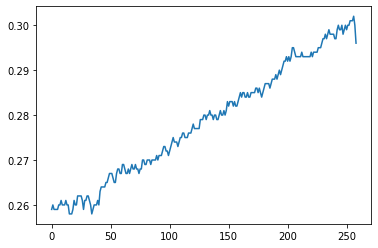

In [ ]:
df['Resistance'].plot()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
train = df_scaled

In [ ]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)


In [ ]:
x_train[0]

array([[0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.20454545],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.22727273],
       [0.        , 0.        , 0.27272727],
       [0.        , 0.        , 0.27272727],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.27272727],
       [0.        , 0.        , 0.27272727],
       [0.        , 0.        , 0.27272727],
       [0.        , 0.        , 0.25      ],
       [0.        , 0.        , 0.27272727]])

In [ ]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [ ]:

# Initialization for system model.
A = 1
H = 1
Q = 0
R = 4
# Initialization for estimation.
x_0 = 0  # 14 for book.
P_0 = 1

In [ ]:
n_samples = len(df)

In [ ]:
x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(x_train, x_esti, P)
        # print(x_esti[1])
print("123", x_esti)
    # x_train[i] = x_esti

123 [[[0.         0.         0.20142262]
  [0.         0.         0.22380291]
  [0.         0.         0.24618321]
  ...
  [0.         0.         0.2685635 ]
  [0.         0.         0.24618321]
  [0.         0.         0.2685635 ]]

 [[0.98473282 0.         0.80569049]
  [0.         0.         0.80569049]
  [0.         0.         0.80569049]
  ...
  [0.         0.         0.87283137]
  [0.         0.         0.87283137]
  [0.         0.         0.91759195]]

 [[0.         0.         0.04476058]
  [0.         0.         0.04476058]
  [0.         0.         0.08952117]
  ...
  [0.         0.         0.04476058]
  [0.         0.         0.04476058]
  [0.         0.         0.06714087]]

 ...

 [[0.         0.         0.46998612]
  [0.98473282 0.         0.49236641]
  [0.         0.         0.5147467 ]
  ...
  [0.         0.         0.55950729]
  [0.98473282 0.         0.58188758]
  [0.         0.         0.60426787]]

 [[0.         0.         0.76092991]
  [0.         0.         0.760929

In [ ]:
y_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(y_train, y_esti, P)
        # print(y_esti)

In [ ]:
model = Sequential()
model.add(LSTM(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(3))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_esti, y_esti, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 1s 10ms/step - loss: 0.3244 - mse: 0.3244
Epoch 2/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.2153 - mse: 0.2153
Epoch 3/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.1495 - mse: 0.1495
Epoch 4/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0657 - mse: 0.0657
Epoch 5/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0190 - mse: 0.0190
Epoch 6/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0038 - mse: 0.0038
Epoch 7/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0032 - mse: 0.0032
Epoch 8/1000
12/12 [==============================] - 0s 9ms/step - loss: 0.0018 - mse: 0.0018
Epoch 9/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0017 - mse: 0.0017
Epoch 10/1000
12/12 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018
Epoch 11/1000
12/12 [=========================

In [ ]:
def mse(label, pred, length):
  for i in range(length):
    error_avg = 0
    error = abs((label[i]-pred[i])/ label[i]*100)
    error_avg = error + error
    return error_avg / length

In [ ]:
new_forecasting= 20

Test Score:  [0.0038892889861017466, 0.0038892889861017466]


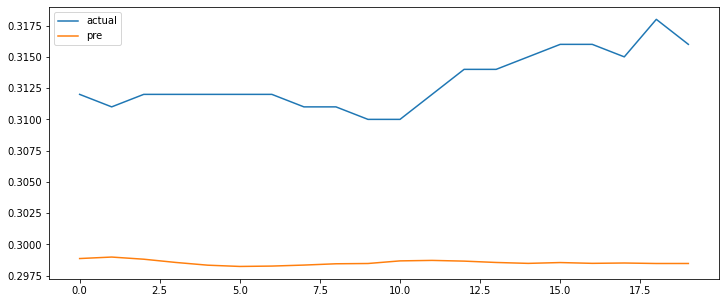

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols
# new_forecasting= len(test)

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting

# print(seq)

test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0017236092826351523, 0.0017236092826351523]


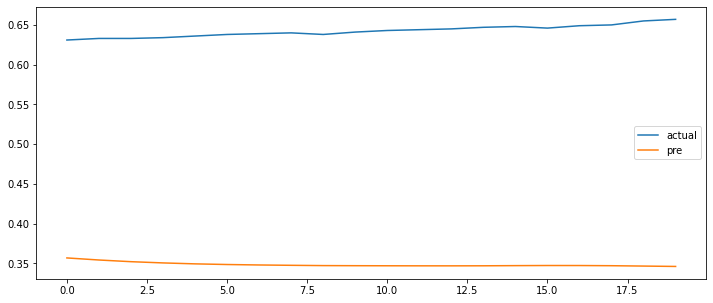

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.001190843409858644, 0.001190843409858644]


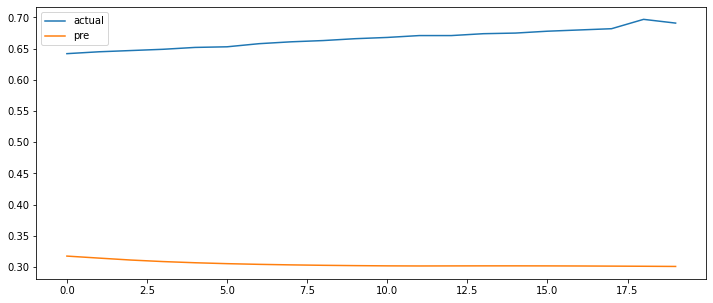

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
# plt.plot(label[:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0024914517998695374, 0.0024914517998695374]


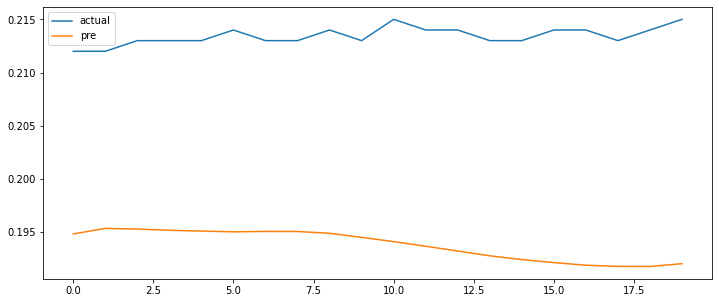

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0017075479263439775, 0.0017075479263439775]


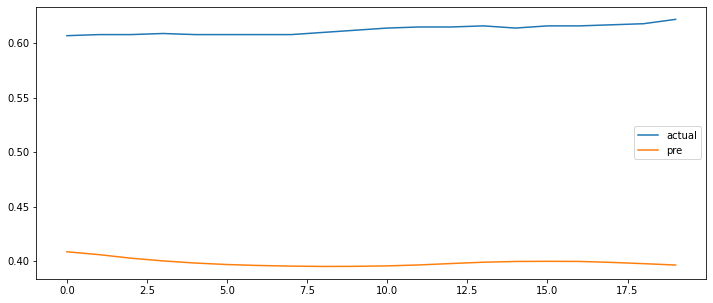

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0029465854167938232, 0.0029465854167938232]


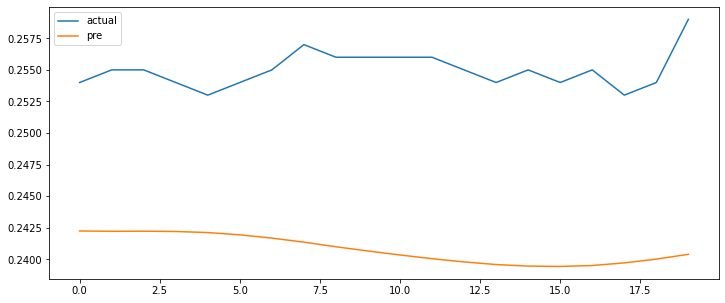

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0020593192894011736, 0.0020593192894011736]


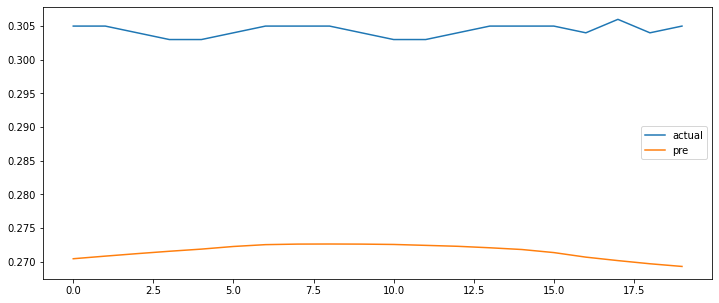

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.005529271438717842, 0.005529271438717842]


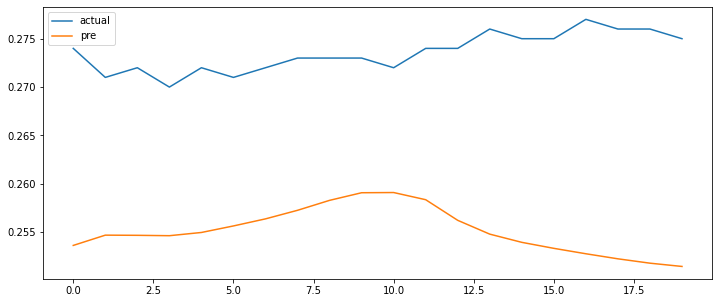

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
# print(test_df)
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
test, seq
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

Test Score:  [0.0004706195031758398, 0.0004706195031758398]


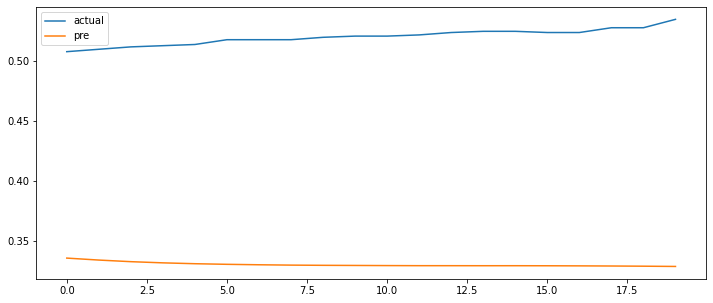

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(test_df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

test = df_scaled
seq = len(test)
seq = round(seq) - new_forecasting


test = test.iloc[0:seq,:]
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

test_feature = test[feature_cols]
test_label = test[label_cols]
test_feature, test_label = make_dataset(test_feature, test_label, new_forecasting)

n_samples = len(test_df)

x_esti, P = None, None
# print("x_train", x_train[10])
for i in range(n_samples):
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(test_feature, x_esti, P)
y_esti, P = None, None
for i in range(n_samples):
    if i == 0:
        y_esti, P = x_0, P_0
    else:
        y_esti, P = kalman_filter(test_label, y_esti, P)



look_ahead=new_forecasting
xhat = x_esti[0]
predictions = np.zeros((look_ahead, 3))
for i in range(look_ahead):
  prediction = model.predict(np.array([xhat]), batch_size=16)
  predictions[i] = prediction
  xhat=np.vstack([xhat[1:],prediction])

label = test_df[label_cols].values

pred2 = scaler.inverse_transform(predictions)
pred2 = pred2[:, 2]
# pred2
# pred2 = predictions[:,2]
testScore = model.evaluate(x_esti, y_esti, batch_size=16, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

plt.figure(figsize=(12,5))
plt.plot(label[-new_forecasting:],label="actual")
plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
pred2

array([0.3355296 , 0.33388978, 0.33254581, 0.33155786, 0.33083738,
       0.3303328 , 0.32995687, 0.32966763, 0.32949568, 0.32938901,
       0.32927772, 0.32919645, 0.32918703, 0.32916095, 0.32917149,
       0.32912458, 0.32904287, 0.32892147, 0.32876385, 0.32855636])

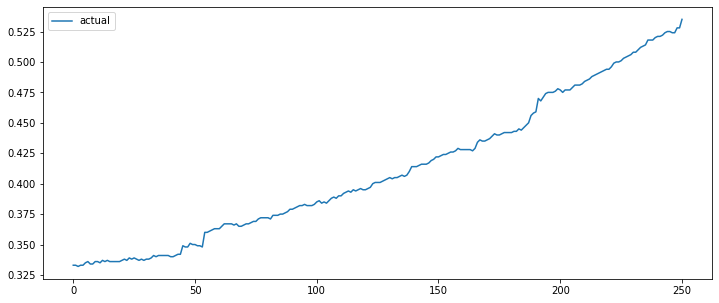

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(label,label="actual")
# plt.plot(pred2,label="pre")
# plt.ylim(0,1)
plt.legend()
plt.show()